<a href="https://colab.research.google.com/github/fedhere/DSPS_FBianco/blob/main/HW6/DSPS_gaussian_process_regression_soln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.datasets import elnino
from scipy import optimize as opt

!pip install george
import george
from george import kernels

!pip install icecream
from icecream.icecream import ic

# NB

Code skeletons are provided for you, but you may change them as you please.

It is not required, but I suggest you adjust and complete the given docstrings as you make changes.

# 0. The Dataset

We'll be using the El Niño dataset from the `statsmodels` package. This first cell of code loads the dataset easily for you. Read the description of the dataset [here](https://www.statsmodels.org/devel/datasets/generated/elnino.html).

In [ ]:
def load_elnino_dataset():
    """
    Downloads the El Niño dataset from the statsmodels package.

    Parameters
    ----------
    None

    Returns
    -------
    df : pd.DataFrame
        A Pandas dataframe containing the raw data of the El Niño dataset
        directly from the statsmodels package.
    """
    df = elnino.load_pandas().data
    return df

df = load_elnino_dataset()

In [ ]:
def flatten_dataset(df):
    """
    Flatten the data in the dataframe.

    The sea surface temperature data is stored in a somewhat peculiar way in
    this dataset. The data has rows for every year between 1950 and 2010, and
    it has 12 columns for each month of each year.

    Re-order the data such that there is one 1dim array for the temperature data.

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas dataframe of the El Niño – Sea Surface Temperature dataset
        from the statsmodels package.

    Returns
    -------
    time : array-like
        A shape (732,) array containing every month from January 1950 to
        December 2010. You may encode the time as an integer
        (`time = [0, 1, 2, 3, ...]), as strings (`time = ['January 1950', ...])
        or however else you like.
    data : array-like
        A shape (732,) array containing the sea surface temperature for every
        month between January 1950 to December 2010.
    """
    start_time = datetime.date(1950, 1, 1)
    end_time = datetime.date(2010, 12, 1)
    time = pd.date_range(start=start_time, end=end_time, freq="MS")

    data = df.values[:, 1:]
    data = data.flatten(order="C")
    return time, data

x, y = flatten_dataset(df)

# 1. Visualize

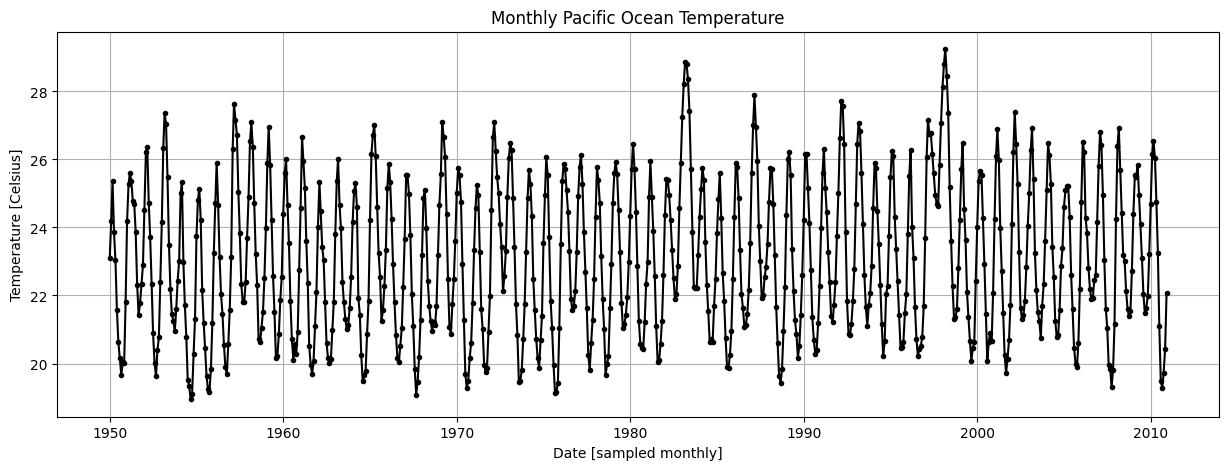

In [ ]:
def visualize(df):
    """
    Visualize the El Niño – Sea Surface Temperature dataset from statsmodels.

    You decide the most appropriate way to visualize the dataset.

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas dataframe of the El Niño – Sea Surface Temperature dataset
        from the statsmodels package.

    Returns
    -------
    None
    """
    time, data = flatten_dataset(df)

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(time, data, "k.-")

    ax.set_title("Monthly Pacific Ocean Temperature")
    ax.set_xlabel("Date [sampled monthly]")
    ax.set_ylabel("Temperature [Celsius]")

    ax.grid()
    fig.show()

    return

visualize(df)

### Figure 1: Monthly-averaged Pacific ocean temperature in degrees Celsius is plotted each month from January 1950 to December 2010. Note the periodicity of the ocean temperatures corresponding to seasonal temperature variations. In 1996-1997 there were unusually high temperatures recorded. This data will be difficult to fit with a Gaussian process (GP) using a simple kernel function for a variety of reasons. First of all, the data is periodic indicating that a non-stationary kernel may be more appropriate. Additionally, from a fundamental perspective, ocean temperatures are likely generated by extremely complex process that includes a significant amount of human intervention. Choosing a kernel function that is not only able to model but also predict this data in the future will be very challenging.

# 2. Gaussian Process Regression (GPR)

In [ ]:
def get_interpolated_time():
    """
    We are going to use GPR to interpolate the sea surface temperatures for
    every day between January 1st 1950 and December 1st 2030. There are 29,555
    days between those two dates. Create and return an array of times for each
    day in that timeframe.

    Paramters
    ---------
    None

    Returns
    -------
    interp_time : array-like
        A shape (29555,) array, the times we want to interpolate. Encoded the
        same way you did before.
    """
    start_time = datetime.date(1950, 1, 1)
    end_time = datetime.date(2030, 12, 1)
    time = pd.date_range(start=start_time, end=end_time, freq="D")
    return time

t = get_interpolated_time()
t.shape

(29555,)

In [ ]:
def gaussian_process_regression(time, data, interp_time, initial_guess):
    """
    Using the george package, its documentation and startup guide, implement a
    simple gaussian process regressor on `time` and `data`. Then, use it to
    predict on `interp_time`.

    Parameters
    ----------
    time : array-like
        A shape (732,) array, times between 1950 and 2010, sampled every month.
    data : array-like
        A shape (732,) array, sea surface temperatures every month between 1950
        and 2010.
    interp_time : array-like
        A shape (29555,) array, times between 1950 and 2030, sampled every day.
    initial_guess : array-like or float
        The intial guess for the gaussian process that you make. The number of
        parameters will depend on the kernel you choose.

    Returns
    -------
    None
    """
    t = time.to_julian_date()
    it = interp_time.to_julian_date()
    kernel = np.var(data) * kernels.ExpSine2Kernel(
        gamma=initial_guess[0],
        log_period=initial_guess[1],
        bounds=[
            (0, None),
            (0, None),
            ]
        )
    gp = george.GP(
        kernel,
        mean=np.mean(data),
        fit_mean=False,
        white_noise=1e-8,
        fit_white_noise=False
        )
    gp.compute(t)

    ic(gp.get_parameter_dict(include_frozen=True))
    ic(gp.get_parameter_bounds())
    ic(gp.log_likelihood(data))

    pred, pred_var = gp.predict(data, it, return_var=True)

    return pred, pred_var

initial_guess = [1000, 10]
p, p_var = gaussian_process_regression(x, y, t, initial_guess)

ic| gp.get_parameter_dict(include_frozen=True): OrderedDict([('mean:value', 23.09262295081967),
                                                             ('white_noise:value', 1e-08),
                                                             ('kernel:k1:log_constant', 1.6168480842330673),
                                                             ('kernel:k2:gamma', 1000.0),
                                                             ('kernel:k2:log_period', 10.0)])
ic| gp.get_parameter_bounds(): [(None, None), (0, None), (0, None)]
ic| gp.log_likelihood(data): -1460.19904734579


The following visualization was not required but I found it very helpful to visualize the result of my initial guess for the kernel parameters. Having a good initial guess for the optimization step later on is important for Gaussian Processes (at least that is what I found with this data and with my previous research).

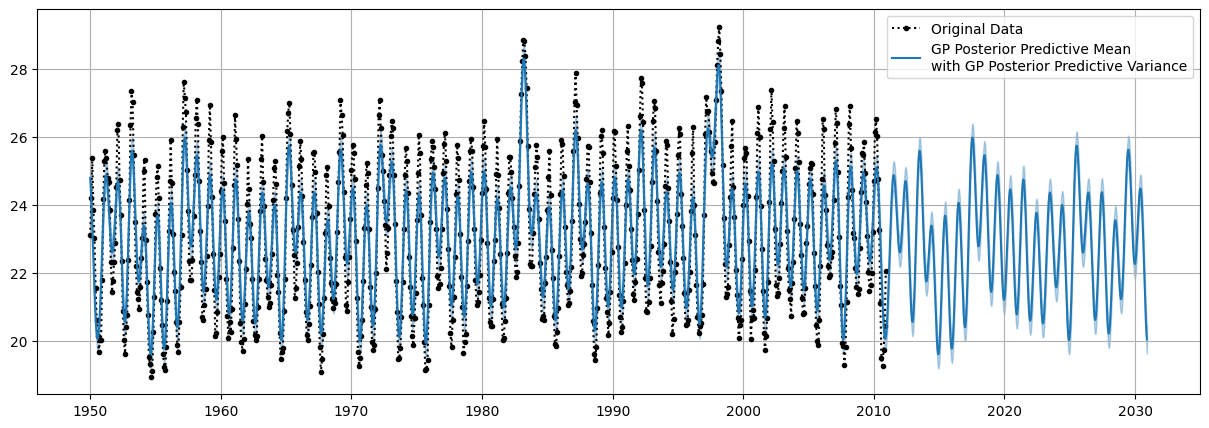

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(x, y, 'k.:', label="Original Data")

ax.plot(t, p, label="GP Posterior Predictive Mean\nwith GP Posterior Predictive Variance")
ax.fill_between(
    t,
    p - np.sqrt(p_var),
    p + np.sqrt(p_var),
    color="tab:blue",
    alpha=0.3,
    )
ax.grid()
ax.legend()

fig.show()

# 3. Optimize

In [ ]:
def optimize(time, data, interp_time, initial_guess):
    """
    Using any optimization method you choose, find the optimal set of
    hyperparameters for your model.

    Parameters
    ----------

    Returns
    -------
    params : array-like
        The optimized parameters of your model.
    """
    t = time.to_julian_date()
    it = interp_time.to_julian_date()
    kernel = np.var(data) * kernels.ExpSine2Kernel(
        gamma=initial_guess[0],
        log_period=initial_guess[1],
        # bounds=[(0, None), (0, None)],
        )
    gp = george.GP(
        kernel,
        mean=np.mean(data),
        fit_mean=True,
        white_noise=1e-8,
        fit_white_noise=True
        )
    gp.compute(t)

    ic(gp.get_parameter_vector())

    # Define the objective function (negative log-likelihood in this case).
    def nll(p, y=data):
        gp.set_parameter_vector(p)
        ll = gp.log_likelihood(y, quiet=True)
        return -ll if np.isfinite(ll) else 1e25

    # And the gradient of the objective function.
    def grad_nll(p, y=data):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(y, quiet=True)

    # You need to compute the GP once before starting the optimization.
    gp.compute(t)

    # Print the initial ln-likelihood.
    ic(gp.log_likelihood(data))

    # Run the optimization routine.
    p0 = gp.get_parameter_vector()
    results = opt.minimize(
        nll,
        p0,
        jac=grad_nll,
        )
    ic(results)

    # Update the kernel and print the final log-likelihood.
    gp.set_parameter_vector(results.x)
    ic(gp.get_parameter_names())
    ic(gp.get_parameter_vector())
    pred, pred_var = gp.predict(data, it, return_var=True)

    return pred, pred_var, gp

initial_guess = [1000, 10]
p, p_var, gp = optimize(x, y, t, initial_guess)

ic| gp.get_parameter_vector(): array([2.30926230e+01, 1.00000000e-08, 1.61684808e+00, 1.00000000e+03,
                                      1.00000000e+01])
ic| gp.log_likelihood(data): -1460.19904734579
ic| results:   message: Optimization terminated successfully.
               success: True
                status: 0
                   fun: 1175.7293682828292
                     x: [ 2.307e+01 -4.028e-02  1.795e+00  4.111e+02  8.992e+00]
                   nit: 31
                   jac: [ 1.459e-07  3.350e-07 -1.435e-07 -6.224e-10  6.503e-06]
              hess_inv: [[ 1.710e-01 -7.247e-05 ...  3.075e-01  3.867e-08]
                         [-7.247e-05  3.192e-03 ... -9.500e-02 -3.726e-08]
                         ...
                         [ 3.075e-01 -9.500e-02 ...  2.594e+03 -1.448e-04]
                         [ 3.867e-08 -3.726e-08 ... -1.448e-04  2.986e-08]]
                  nfev: 42
                  njev: 42
ic| gp.get_parameter_names(): ('mean:value',
                  

# 4. Visualize your model

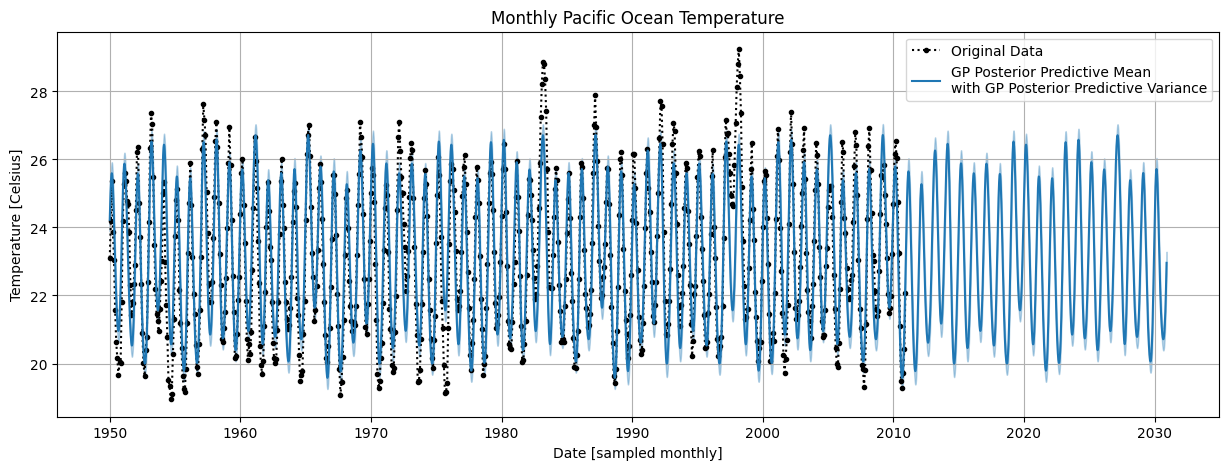

In [ ]:
def visualize_model(x, y, t, p, p_var):
    """
    Visualize your model. Use any method you like in visualizing your model but
    you must make at least one plot with a figure caption.

    Parameters
    ----------


    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(x, y, 'k.:', label="Original Data")

    ax.plot(t, p, label="GP Posterior Predictive Mean\nwith GP Posterior Predictive Variance")
    ax.fill_between(t, p - np.sqrt(p_var), p + np.sqrt(p_var), color="tab:blue", alpha=0.3)

    ax.set_title("Monthly Pacific Ocean Temperature")
    ax.set_xlabel("Date [sampled monthly]")
    ax.set_ylabel("Temperature [Celsius]")

    ax.grid()
    ax.legend()
    fig.show()

visualize_model(x, y, t, p, p_var)

### Figure 2: The black dotted line plots monthly-averaged Pacific ocean temperatures in degrees Celsisus from January 1950 to December 2010. The blue solid line plots the output of the GP regression optimization which has interpolated the ocean temperatures every day between January 1st 1950 and December 1st 2030. The blue shaded region shows 1-sigma uncertainties obtained from the GP posterior predictive variance while the line plots the GP posterior predictive mean. Overall, the GP model I fit had five parameters: mean, 23.07; white noise, -0.0402; k1 log constant, 1.794; k2 gamma, 411.0; k2 log period, 8.991. This mode interpolates the data reasonable well between datapoints, and beyond 2010 the data is reasonably predicted as periodicm though no doubt the model does not take into account rising sea temperatures do to climate change or any other extraneous factors. In fact, the increased temperatures in 1996-97 are not well predicted by this model.